Load the usual libraries

In [1]:
import math  
import os   
import glob 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats


In [74]:
# Path to the folder where all the raw data is located
src = '/home/ejam/documents/css893/GoGreen/sample_data/'

# Path where we will save outputs
dst = '/home/ejam/documents/css893/output/'

# Matrix with imputed SNP data
file_snp_imp = 'snp_imputed_chr10.csv'

# Matrix with gene expression (FPKM)
file_gen = 'gene_w_features_chr10.csv'

file_zfpkm = 'zfpkm_chr10.csv'

file_ztpm = 'ztpm_chr10.csv'

Load the genes and their respective regions. Notice that we do **not** need the actual gene expression information.

In [27]:
fpkm = pd.read_csv(src+file_gen, usecols=['gene', 'chromosome', 'position_left', 'position_right'])
fpkm

,gene,chromosome,position_left,position_right
0,Zm00001d024742,10,85863323,85863746
1,Zm00001d025653,10,125107973,125113328
2,Zm00001d024903,10,93908316,93911235
3,Zm00001d023618,10,12298031,12300071
4,Zm00001d024825,10,89733155,89739279
...,...,...,...,...
2982,Zm00001d023459,10,6289475,6298739
2983,Zm00001d026184,10,140529821,140530718
2984,Zm00001d024000,10,35675291,35679293
2985,Zm00001d025251,10,111149588,111152196


Load the previously computed z-scores from TPMs. Compute the variance of the z-scores across all cultivars. 

We select those genes whose variance is above 45. 

In [103]:
var_cutoff = 45
ztpm = pd.read_csv(src+file_ztpm)
ztpm['var'] = ztpm.var(axis='columns')
high_z = ztpm[ztpm['var'] > var_cutoff]
fpkm_high_z = fpkm.iloc[high_z.index]
fpkm_high_z

,gene,chromosome,position_left,position_right
63,Zm00001d023568,10,10478273,10478636
120,Zm00001d024475,10,72600342,72603299
167,Zm00001d023900,10,27174145,27174732
320,Zm00001d025225,10,110101287,110101653
356,Zm00001d024975,10,97685326,97689706
392,Zm00001d025308,10,113713985,113714453
439,Zm00001d023571,10,10559154,10563126
451,Zm00001d023759,10,19056768,19063074
473,Zm00001d023857,10,25235893,25236857
496,Zm00001d023562,10,10266211,10266655


Scatter plot of the variance of zTPMs across all cultivars. The red line is the chose cutoff.

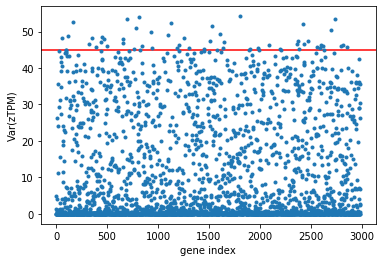

In [105]:
plt.xlabel('gene index')
plt.ylabel('Var(zTPM)')
plt.axhline(var_cutoff, c='r')
plt.plot(ztpm['var'], '.')

Load **only** the position of the SNPs (this will make the next computation faster)

In [75]:
snps = pd.read_csv(src+file_snp_imp, usecols=['chrom', 'pos'])
snps

,chrom,pos
0,10,130347
1,10,130350
2,10,130488
3,10,130523
4,10,130656
...,...,...
61457,10,150833697
61458,10,150833709
61459,10,150833722
61460,10,150833724


Sort the genes with high variance in expression according to their left position. 

We assume that the gene regions **do not** overlap.

In [65]:
pos_sorted = fpkm_high_z.sort_values(by=['position_left'], ascending=True)
pos_sorted

,gene,chromosome,position_left,position_right
1996,Zm00001d023269,10,1698335,1698995
2811,Zm00001d023387,10,4374701,4375148
1651,Zm00001d023552,10,9848877,9850164
496,Zm00001d023562,10,10266211,10266655
63,Zm00001d023568,10,10478273,10478636
439,Zm00001d023571,10,10559154,10563126
451,Zm00001d023759,10,19056768,19063074
473,Zm00001d023857,10,25235893,25236857
167,Zm00001d023900,10,27174145,27174732
942,Zm00001d023995,10,35301875,35306863


Check for the left-most and right-most values of all gene regions.

In [106]:
start = pos_sorted.iloc[0]['position_left']
end = pos_sorted.iloc[-1]['position_right']
print(start, end)

1698335 147433738


Loop **once** through all the SNP positions and all the gene regions. 

Keep a record of **only** the SNPs that are present in highly variating genes.

In [77]:
SNP = []
gene = []
gene_idx = []
current = 0
for i in range(snps.shape[0]):
    pos = snps.iloc[i]['pos']
    if pos < start or pos > end:
        pass
    else:
        for j in range(current, pos_sorted.shape[0]):
            left, right = pos_sorted.iloc[j][['position_left', 'position_right']]
            if pos <= right:
                current = j
                if pos >= left:
                    SNP.append(i)
                    gene.append(pos_sorted.iloc[j]['gene'])
                    gene_idx.append(pos_sorted.index[j])
                    in_gene = True
                break

In [78]:
print(fpkm.iloc[2874][['position_left', 'position_right']])
snps_high_z = snps.iloc[SNP]
snps_high_z = snps_high_z.assign(gene=gene)
snps_high_z = snps_high_z.assign(gene_idx=gene_idx)
snps_high_z

position_left     95794146
position_right    95805417
Name: 2874, dtype: object


,chrom,pos,gene,gene_idx
6224,10,4374911,Zm00001d023387,2811
6225,10,4374927,Zm00001d023387,2811
6226,10,4374945,Zm00001d023387,2811
9257,10,9848972,Zm00001d023552,1651
9258,10,9848977,Zm00001d023552,1651
...,...,...,...,...
55826,10,147354710,Zm00001d026509,659
55827,10,147354719,Zm00001d026509,659
55828,10,147354742,Zm00001d026509,659
55829,10,147354782,Zm00001d026509,659


Verify that the cell above did what it was intended to do.

In [80]:
val = 270
idx = snps_high_z.iloc[val]['gene_idx']
print(snps_high_z.iloc[val]['pos'])
print()
print(fpkm.iloc[idx][['position_left', 'position_right']])

147354782

position_left     147354475
position_right    147354799
Name: 659, dtype: object


Now load **all** the SNPs and save only those that are present in highly varying genes.

In [89]:
snps = pd.read_csv(src+file_snp_imp)
snps = snps.iloc[SNP]
snps = snps.assign(gene=gene)
cols = snps.columns.values[:-1]
cols = np.insert(cols,0,'gene')
snps = snps[cols]
snps.to_csv(dst + 'high_z_snps.csv', index=False)

Same idea with the TPMs. In this notebook, we need to re-compute the TPM values.

In [111]:
fpkm = pd.read_csv(src+file_gen)
total_exp = fpkm.iloc[:, 5:].sum(axis='index')
tpm = fpkm.iloc[:, 5:]*1e6
tpm = tpm.div(other=total_exp, axis='columns')
tpm = tpm.iloc[high_z.index]
tpm = pd.concat([fpkm_high_z, tpm], axis='columns')
tpm.to_csv(dst + 'high_z_tpm.csv', index=False)